In [27]:
import torch
from torch import nn
import torch.autograd.forward_ad as fwAD
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="/home/yequan/Project/TensorFusionOperatorLearning/data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="/home/yequan/Project/TensorFusionOperatorLearning/data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 1

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 256, bias=True)
        self.nl1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256, bias=True)
        self.nl2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10, bias=True)

    def forward(self, x):
        # x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.nl1(x)
        x = self.fc2(x)
        x = self.nl2(x)
        output = self.fc3(x)
        return output

model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("./temp/model.pth"))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=1e-3)

sigma = 1
STP = True

def get_gradient_vec(model):
    gradients_list = []
    for param in model.parameters():
        if param.grad is not None:
            gradients_list.append(param.grad.view(-1))
        else:
            param.requires_grad_(False)
    gradients_vec = torch.cat(gradients_list)

    return gradients_vec 

def split_model(model):
    modules = []
    for m in model.children():
        if isinstance(m, (torch.nn.Sequential,)):
            modules += split_model(m)
        else:
            modules.append(m)
    return modules

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    X, y = next(iter(dataloader))
    for batch in range(1):
    # for batch, (X, y) in enumerate(dataloader):
    
        X, y = X.to(device), y.to(device)
        X.requires_grad_(True)

        X = torch.flatten(X,1)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        BP_X_grad = torch.autograd.grad(loss, X, create_graph=True)[0] # before loss.backward()
        loss.backward()
        FO_grad = get_gradient_vec(model)

        # ZO-CGE to get input gradient
        optimizer.zero_grad()
        
        X_grad = torch.zeros_like(X, device=device)

        for idx in range(X.shape[-1]):
            tangent = torch.zeros(X.shape, device=device)
            tangent[0][idx] = 1.0
            with fwAD.dual_level():
                dual_input = fwAD.make_dual(X, tangent)
                assert fwAD.unpack_dual(dual_input).tangent is tangent
                
                pred_dual = model(dual_input)
                loss_dual = loss_fn(pred_dual, y)

                # Unpacking the dual returns a ``namedtuple`` with ``primal`` and ``tangent`` as attributes
                X_grad[0][idx] = fwAD.unpack_dual(loss_dual).tangent
        
        # for idx in range(X.shape[-1]):
        #     old_value = X.data[0][idx] * 1.0

        #     pos_perturbed_value = old_value + sigma
        #     neg_perturbed_value = old_value - sigma

        #     with torch.no_grad():  # training=True to enable profiling, but do not save graph
        #         X.data[0][idx] = pos_perturbed_value  
        #         # print(X.data[0][idx])    
        #         temp_y = model(X)
        #         pos_loss = loss_fn(pred, y)

        #         if STP == True:
        #             X.data[0][idx] = neg_perturbed_value
        #             # print(X.data[0][idx])
        #             temp_y = model(X)
        #             neg_loss = loss_fn(pred, y)

        #             X_grad[0][idx] = (pos_loss-neg_loss)/2/sigma
        #         else:
        #             X_grad[0][idx] = (pos_loss-loss)/sigma
                
        #         X.data[0][idx] = old_value
        
        print('BP_X_grad norm:', torch.linalg.norm(BP_X_grad.view(-1)))
        print('ZO_X_grad norm:', torch.linalg.norm(X_grad.view(-1)))
        print('BP_X_grad-ZO_X_grad error norm:', torch.linalg.norm(BP_X_grad.view(-1)-X_grad.view(-1)))
        
        # Forward chains rule
        y1 = model.nl1(model.fc1(X))
        mask = torch.sign(y1)
        b1_grad = F.linear(X_grad, model.fc1.weight, None)
        y1_grad = F.linear(X_grad, model.fc1.weight, None) * mask
        # y1_grad = model.fc1(X_grad) * mask

        W1_grad = torch.outer(y1_grad.squeeze(), X.squeeze())
        model.fc1.weight.grad = W1_grad
        model.fc1.bias.grad = b1_grad.squeeze()

        y2 = model.nl2(model.fc2(y1))
        mask = torch.sign(y2)
        b2_grad = F.linear(y1_grad, model.fc2.weight, None)
        y2_grad = F.linear(y1_grad, model.fc2.weight, None) * mask

        W2_grad = torch.outer(y2_grad.squeeze(), y1.squeeze())
        model.fc2.weight.grad = W2_grad
        model.fc2.bias.grad = b2_grad.squeeze()

        y3 = model.fc3(y2)
        b3_grad = F.linear(y2_grad, model.fc3.weight, None)
        y3_grad = F.linear(y2_grad, model.fc3.weight, None)

        W3_grad = torch.outer(y3_grad.squeeze(), y2.squeeze())
        model.fc3.weight.grad = W3_grad
        model.fc3.bias.grad = b3_grad.squeeze()

        ZO_grad = get_gradient_vec(model)

        print('FO_grad norm:', torch.linalg.norm(FO_grad))
        print('ZO_grad norm:', torch.linalg.norm(ZO_grad))
        print('FO_grad-ZO_grad error norm:', torch.linalg.norm(FO_grad-ZO_grad))

        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = torch.flatten(X,1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
    torch.save(model.state_dict(), "./temp/model.pth")
    print("Saved PyTorch Model State to model.pth")
print("Done!")

Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64
Using cuda device
Epoch 1
-------------------------------
BP_X_grad norm: tensor(4.5050e-07, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
ZO_X_grad norm: tensor(4.5833e-07, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
BP_X_grad-ZO_X_grad error norm: tensor(1.5386e-07, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [13]:
import torch
import torch.autograd.forward_ad as fwAD

primal = torch.arange(1,11,dtype=torch.float32)
tangent = torch.zeros(10)
tangent[0] = 1

def fn(x, y):
    return x ** 2 + y ** 2

# All forward AD computation must be performed in the context of
# a ``dual_level`` context. All dual tensors created in such a context
# will have their tangents destroyed upon exit. This is to ensure that
# if the output or intermediate results of this computation are reused
# in a future forward AD computation, their tangents (which are associated
# with this computation) won't be confused with tangents from the later
# computation.
with fwAD.dual_level():
    # To create a dual tensor we associate a tensor, which we call the
    # primal with another tensor of the same size, which we call the tangent.
    # If the layout of the tangent is different from that of the primal,
    # The values of the tangent are copied into a new tensor with the same
    # metadata as the primal. Otherwise, the tangent itself is used as-is.
    #
    # It is also important to note that the dual tensor created by
    # ``make_dual`` is a view of the primal.
    dual_input = fwAD.make_dual(primal, tangent)
    assert fwAD.unpack_dual(dual_input).tangent is tangent

    # Tensors that do not have an associated tangent are automatically
    # considered to have a zero-filled tangent of the same shape.
    plain_tensor = torch.arange(1,11,dtype=torch.float32)
    dual_output = fn(dual_input, plain_tensor)

    # Unpacking the dual returns a ``namedtuple`` with ``primal`` and ``tangent``
    # as attributes
    jvp = fwAD.unpack_dual(dual_output).tangent
    print(jvp)

assert fwAD.unpack_dual(dual_output).tangent is None

tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [3]:
import torch

# Assume A is your tensor
A = [0, 1, 2, 4, 3, 9]

B = A[:-1][::-1]

print(B)


[3, 4, 2, 1, 0]


In [ ]:
torch.save(FO_grad, '/home/yequan/Project/tiny-training/temp/8_FO_1.pth')
torch.save(ZO_grad, '/home/yequan/Project/tiny-training/temp/8_ZO_1.pth')

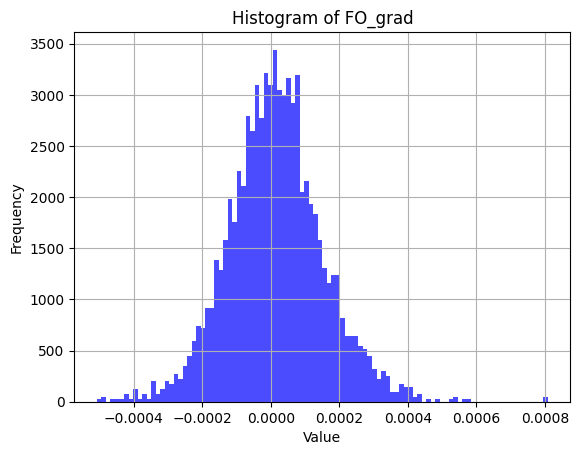

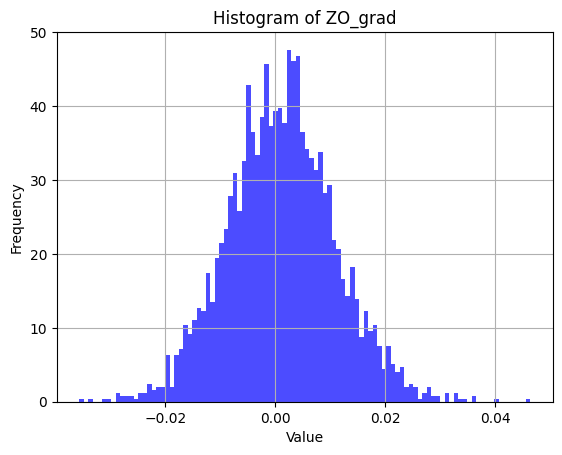

In [22]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

FO_grad = torch.load('/home/yequan/Project/tiny-training/temp/8_FO_50.pth')
ZO_grad = torch.load('/home/yequan/Project/tiny-training/temp/8_ZO_50.pth')

FO_grad = torch.sum(FO_grad, dim=0)
ZO_grad = torch.sum(ZO_grad, dim=0)

# FO_grad = F.normalize(FO_grad, p=2, dim=0)
# ZO_grad = F.normalize(ZO_grad, p=2, dim=0)

FO_grad = FO_grad.detach().cpu().view(-1)
ZO_grad = ZO_grad.detach().cpu().view(-1)

dimension = FO_grad.numel()

# Plot histogram
plt.hist(FO_grad, bins=100, density=True, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of FO_grad')
plt.grid(True)
plt.show()

plt.hist(ZO_grad, bins=100, density=True, alpha=0.7, color='blue')  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of ZO_grad')
plt.grid(True)
plt.show()

# # Plot histogram
# plt.hist(FO_grad, bins=100, density=True, alpha=0.7, label='FO_grad')  # Adjust the number of bins as needed
# plt.hist(ZO_grad, bins=100, density=True, alpha=0.7, label='ZO_grad')  # Adjust the number of bins as needed

# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of FO_grad and ZO_grad')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot curve
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Curve of FO_grad and ZO_grad')
# plt.legend()
# plt.grid(True)

# plt.scatter(range(dimension), FO_grad, label='FO_grad', s=1)  # Adjust the number of bins as needed
# plt.show()
# plt.scatter(range(dimension),ZO_grad, label='ZO_grad', s=1)  # Adjust the number of bins as needed
# plt.show()

In [11]:
import torch

a = torch.randint(1,5,size=(2,3,1,1))
b = torch.randint(1,5,size=(2,3))
c = a * b

print(a.squeeze()[1,1])
print(b)
print(c.squeeze()[1,1])

tensor(3)
tensor([[1, 2, 3],
        [4, 2, 2]])
tensor([[ 3,  6,  9],
        [12,  6,  6]])


In [17]:
import torch

b = torch.randint(1,5,size=(2,3,4))

print(b)
torch.min(b, dim=1)

tensor([[[4, 3, 2, 2],
         [4, 4, 1, 1],
         [2, 3, 4, 1]],

        [[1, 2, 2, 3],
         [1, 3, 3, 1],
         [3, 2, 4, 2]]])


torch.return_types.min(
values=tensor([[2, 3, 1, 1],
        [1, 2, 2, 1]]),
indices=tensor([[2, 0, 1, 1],
        [0, 0, 0, 1]]))